<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV


from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer, mean_squared_error 
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.index.is_monotonic

True

In [6]:
#выполним ресемплирование по одному часу
data = data.resample('1H').sum()

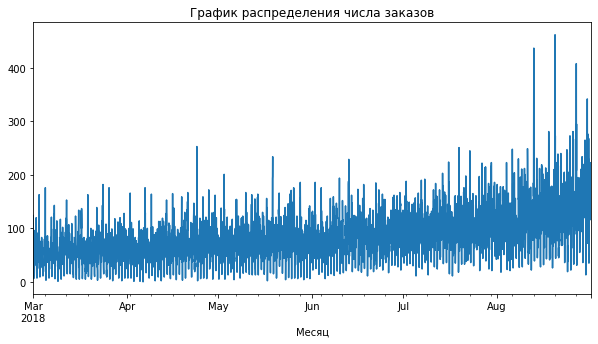

In [7]:
data['num_orders'].plot(subplots=True, figsize=(10, 5))

plt.title('График распределения числа заказов')
plt.xlabel('Месяц')

plt.show()

**ВЫВОД 1:**

В нашем распоряжении данные за период 2018-03-01 : 2018-08-31, целевой признак 'num_orders' хранит количество заказов. 
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

На первом этапе мы загрузили и подготовили данные, сделали ресемплирование по 1 часу, построили график распределения частот 

## Анализ

In [8]:
decomposed = seasonal_decompose(data)

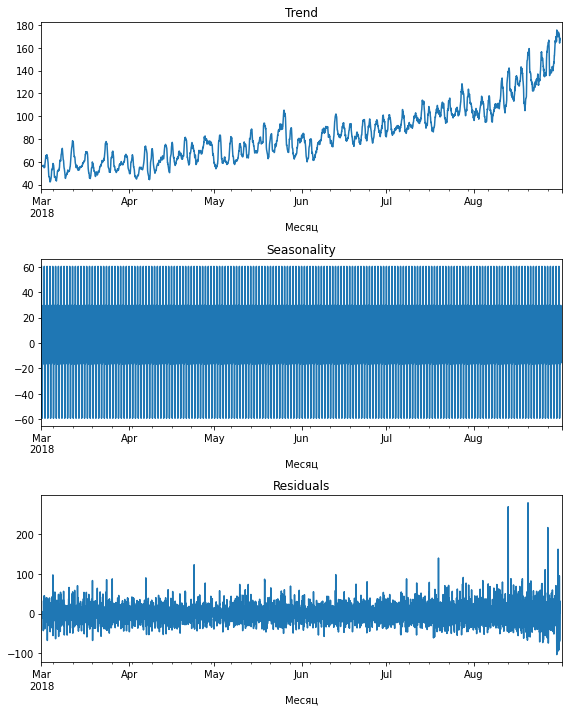

In [9]:
plt.figure(figsize=(8, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Месяц')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Месяц')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Месяц')
plt.tight_layout()

На этом этапе виден четко выраженный тренд: за пять месяцев количество заказов увеличевается. Рост начинается в теплое время года: Май, Июнь, Июль, Август.

Так как тренды и сезонность зависят от масштаба данных. Нельзя увидеть закономерности, повторяющиеся каждое лето, если есть данные только за полгода.

График сезонности в данном масштабе малоинформативен, сделаем срез данных за неделю и посмотрим на результат:

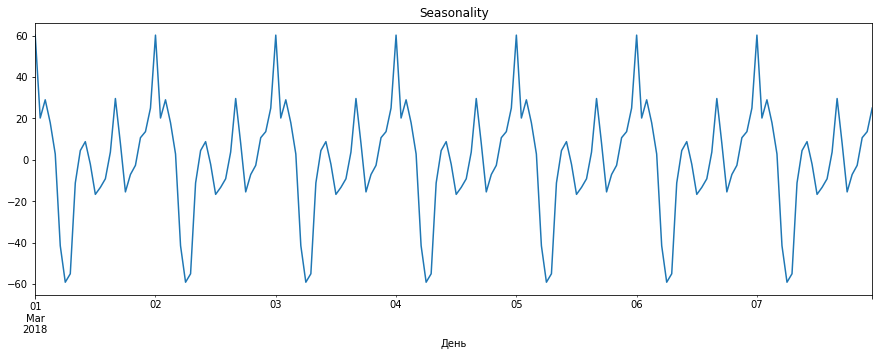

In [10]:
plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('День')

plt.show()

График сезонности показывает что количество заказов увеличивается на протяжении одного дня

Построим график показывающий стандартное отклонение по скользящему окну:

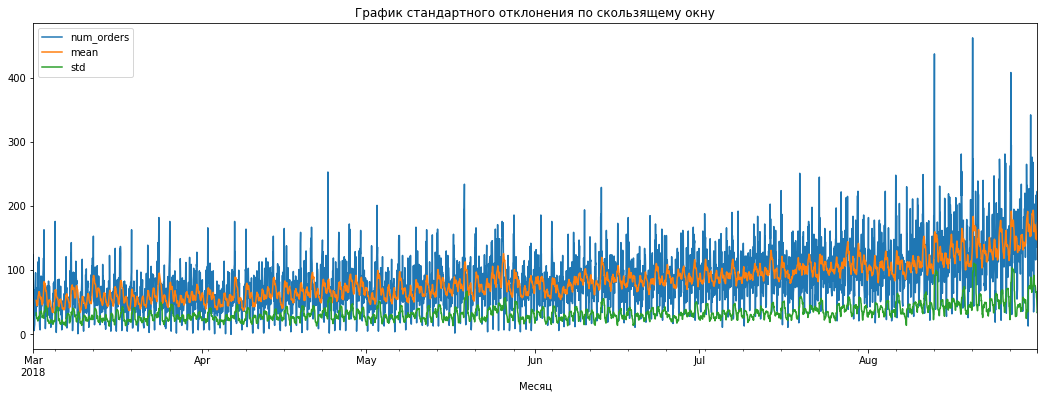

In [11]:
df = data.copy()
df['mean'] = data['num_orders'].rolling(15).mean()
df['std'] = data['num_orders'].rolling(15).std()
df.plot(figsize=(18, 6))

plt.title('График стандартного отклонения по скользящему окну')
plt.xlabel('Месяц')
plt.show()

Построим график распределения разностей времянного ряда

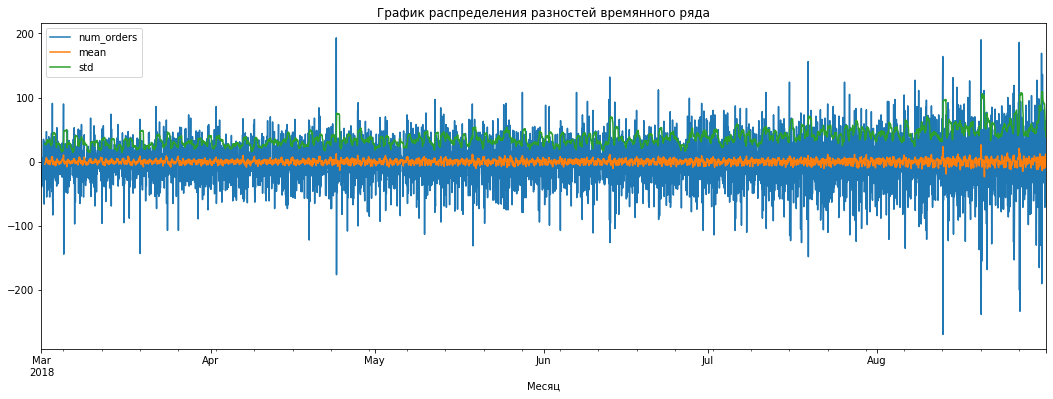

In [12]:
df = df - df.shift()

df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot(figsize=(18, 6))

plt.title('График распределения разностей времянного ряда')
plt.xlabel('Месяц')
plt.show()

**ВЫВОД 2:**

* Данные показывают суточную сезонность: минимальная точка начинается с полночи и далее на протяжении дня наблюдается рост 

## Обучение

Напишем функцию make_features(), чтобы прибавить к таблице три новых признака: день, день недели и час

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    
    df_new = df.copy()
    
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    #максимальный размер отставания
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    #скользящее среднее    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df_new

In [14]:
make_features(data, 24, 10)

In [15]:
data.head(2)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
data = data.dropna()

In [17]:
data.isna().sum()

num_orders      0
day             0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64

In [18]:
data.head(2)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,61.7
2018-03-02 01:00:00,120,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.9


In [19]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop('num_orders', axis=1), data.num_orders, test_size=0.1, shuffle=False)

In [20]:
print('Тренировочная выборка:', features_train.shape)
print('Тестовая выборка:', features_test.shape)
print()
print('Целевой признак тренировочная выборки:', target_train.shape)
print('Целевой признак тестовой выборки:', target_test.shape)

Тренировочная выборка: (3952, 28)
Тестовая выборка: (440, 28)

Целевой признак тренировочная выборки: (3952,)
Целевой признак тестовой выборки: (440,)


С помощью StandardScaler() стандартизируем данные

In [21]:
#Создадим объект этой структуры и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train) 

StandardScaler()

In [22]:
#Сохраним проеобразование для тренировочный выборки 
features_train = scaler.transform(features_train)

In [23]:
#Сохраним проеобразование для тестовой выборки
features_test = scaler.transform(features_test)

In [24]:
#функция для вычисления RMSE
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5

Так как перед нами задача минимизации метрики RMSE, и подбор параметров бедет проводится с GridSearchCV - указываем greater_is_better=False. Чтобы убрать минус домножаем на -1 

In [25]:
#подготовим скорер 
rmse_score = make_scorer(RMSE, greater_is_better=False)

**LinearRegression**

In [26]:
%%time
#Количество разделений n_splits=5
time_cv = TimeSeriesSplit(n_splits=5)

model = LinearRegression()
model.fit(features_train, target_train)

scores = cross_val_score(model, 
                         features_train, 
                         target_train,
                         scoring=rmse_score,
                         cv=time_cv) 

final_score = pd.Series(scores).mean()*(-1)

print('----------------')
print("Среднее абсолютных разностей между наблюдаемым и предсказанным значениями:", final_score)
print('----------------')

----------------
Среднее абсолютных разностей между наблюдаемым и предсказанным значениями: 27.15147999894407
----------------
CPU times: user 251 ms, sys: 496 ms, total: 747 ms
Wall time: 748 ms


**CatBoostRegressor**

In [27]:
%%time
#Количество разделений n_splits=5
time_cv = TimeSeriesSplit(n_splits=5)

model = CatBoostRegressor(verbose=False)
params = {'learning_rate': [0.03, 0.1],
          "depth": [4, 6, 10],
          "iterations": [60]}

grid = GridSearchCV(model, params, cv=time_cv)
grid.fit(features_train, target_train)

scores = cross_val_score(grid, 
                         features_train, 
                         target_train,
                         scoring=rmse_score,
                         cv=time_cv) 

final_score = pd.Series(scores).mean()*(-1)

print('----------------')
print('Оптимальные гиперпараметры:', grid.best_params_)
print("Среднее абсолютных разностей между наблюдаемым и предсказанным значениями:", final_score)
print('----------------')

----------------
Оптимальные гиперпараметры: {'depth': 6, 'iterations': 60, 'learning_rate': 0.1}
Среднее абсолютных разностей между наблюдаемым и предсказанным значениями: 25.166995448002403
----------------
CPU times: user 2min 34s, sys: 1.45 s, total: 2min 35s
Wall time: 4min 49s


**RandomForestRegressor**

In [28]:
%%time
#Количество разделений n_splits=5
time_cv = TimeSeriesSplit(n_splits=5)

model = DecisionTreeRegressor()
params = {'max_depth': range (1, 13, 2),
          'min_samples_leaf': range (1, 8),
          'min_samples_split': range(2, 8, 2)}
 
grid = GridSearchCV(model, params, cv=time_cv)
grid.fit(features_train, target_train)

scores = cross_val_score(grid, 
                         features_train, 
                         target_train,
                         scoring=rmse_score,
                         cv=time_cv) 

final_score = pd.Series(scores).mean()*(-1)

print('----------------')
print('Оптимальные гиперпараметры:', grid.best_params_)
print("Среднее абсолютных разностей между наблюдаемым и предсказанным значениями:", final_score)
print('----------------')

----------------
Оптимальные гиперпараметры: {'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}
Среднее абсолютных разностей между наблюдаемым и предсказанным значениями: 29.26170036342548
----------------
CPU times: user 42.7 s, sys: 58.6 ms, total: 42.8 s
Wall time: 42.8 s


**ВЫВОД 3:**
На этапе 3 мы реализовали функцию для создания признаков:
* добавили календарные признаки
* отстающие значения
* скользящее среднее

Обучили три модели ML. Тестирование будем проводить на модели CatBoostRegressor, так как у него лучший показатель метрики rmse

## Тестирование

In [29]:
%%time
model = CatBoostRegressor(depth=6, iterations=60, learning_rate=0.1, verbose=0)
model.fit(features_train, target_train)

predict = model.predict(features_test)
rmse = mean_squared_error(target_test, predict)
print("Среднее абсолютных разностей между наблюдаемым и предсказанным значениями:", rmse**0.5)

Среднее абсолютных разностей между наблюдаемым и предсказанным значениями: 45.66731232023949
CPU times: user 365 ms, sys: 159 µs, total: 365 ms
Wall time: 1.01 s


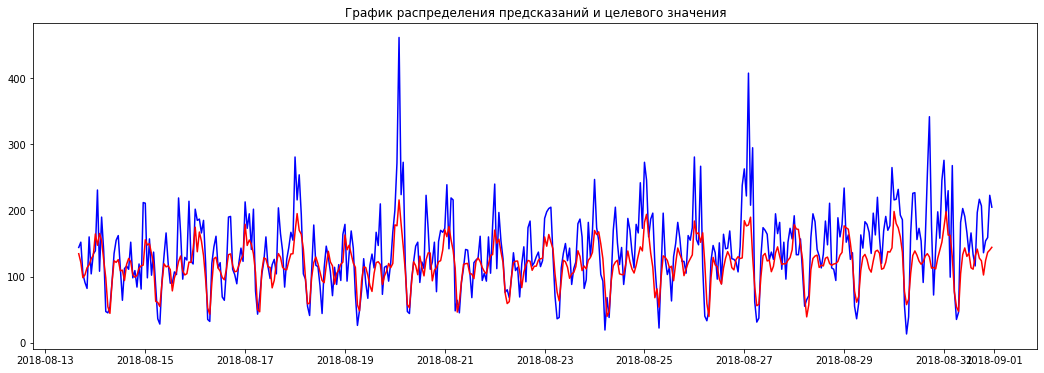

In [34]:
plt.figure(figsize=(18, 6))
plt.plot(target_test.index, target_test, 'b-', 
         target_test.index, predict, 'r-')

plt.title('График распределения предсказаний и целевого значения')
plt.show()

Спрогнозировать временные ряды без обучения можно двумя способами:

1. Все значения тестовой выборки предсказываются одним и тем же числом (константой).
2. Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1). Этот способ не зависит от метрики.

Воспользуемся вторым способом и проверим модель на адекватность:

In [31]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

In [32]:
print("Средний объём заказов:", target_test.mean())
print("------------------")
print("RMSE:", mean_squared_error(target_test, pred_previous)**0.5)

Средний объём заказов: 139.56136363636364
------------------
RMSE: 58.881776776551476


Проверка на адекватность есть 🙌

**ОБЩИЙ ВЫВОД:**

В рамках проекта были представлены данные компании «Чётенькое такси».

Цель проекта: Разработка модели ML для прогноза количества заказов такси на следующий час.

Для достижения цели необходимо выполнить следущие критерий заказчика:
* Значение метрики RMSE на тестовой выборке должно быть не больше 48

В процессе реализации проекта были выполнены следующие шаги:
   - Проведена преобработка и анализ данных;
   - Обучены 3 модели;
   - Была выбрана модель CatBoostRegressor и проверена на тестовой выборке.
   
Показатель rmse модели CatBoostRegressor на тестовой выборке равен 45